## Q1. Augmentation Implementation
### Implement augmentation by finishing train_tfm in the code with image size of your choice. 
### Directly copy the following block and paste it on GradeScope after you finish the code
#### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
#### Your  train_tfm in the report can be different from train_tfm in your training code.

In [ ]:
train_tfm = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128 pixels
    transforms.TrivialAugmentWide(),  # Apply a custom image augmentation that perturbs the brightness and contrast of the image
    transforms.RandomHorizontalFlip(p=0.1),  # Randomly flip the image horizontally with a probability of 0.1
    transforms.RandomVerticalFlip(p=0.1),  # Randomly flip the image vertically with a probability of 0.1
    transforms.RandomResizedCrop(128, scale=(0.4,1.0),ratio=(0.95,1.05)),  # Randomly crop and resize the image with a scaling factor between 0.4 and 1.0 and aspect ratio between 0.95 and 1.05
    transforms.RandomRotation(30),  # Randomly rotate the image by up to 30 degrees
    transforms.RandomGrayscale(p=0.1),  # Randomly convert the image to grayscale with a probability of 0.1
    transforms.ColorJitter(brightness=0.25),  # Randomly adjust the brightness of the image by up to 0.25
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize([0.4598, 0.3836, 0.3001],[0.3105, 0.2908, 0.2802]),  # Normalize the pixel values based on the given mean and standard deviation values for each color channel
])

## Q2. Visual Representations Implementation
### Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images). 
### ChatGPT has generated the following code, which requires a minor modification to produce the expected results.

In [18]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm import tqdm
import random
from torchvision.transforms.autoaugment import AutoAugmentPolicy, TrivialAugmentWide

In [19]:
_exp_name = "sample798"

In [20]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.15),
    transforms.RandomVerticalFlip(p=0.15),
    transforms.RandomAffine(degrees=10, translate=(0.2,0.2)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
    transforms.Normalize([0,0,0],[1,1,1])
])

In [21]:
class FoodDataset(Dataset):
    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        #im = self.data[idx]
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label

In [22]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input dim [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [27]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
# Load the trained model
model = Classifier().to(device)
state_dict = torch.load(f"{_exp_name}_best.ckpt")#, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

print(model)

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [24]:
print(model.cnn[:12])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


One ./valid sample ./valid/0_0.jpg
cuda


100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


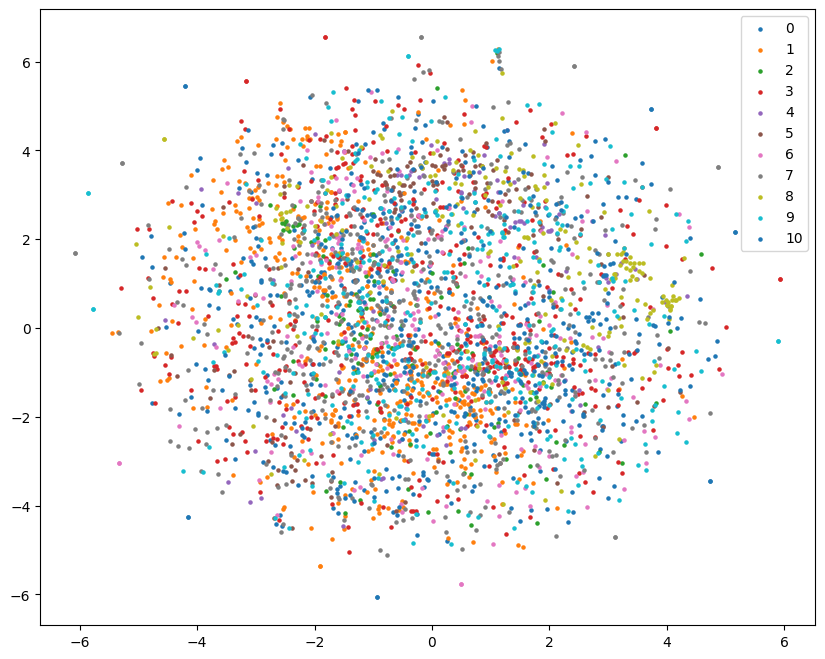

In [28]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
print(device)
# Extract the representations for the specific layer of model
# index = ... # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:12](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    
features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

100%|██████████| 29/29 [00:05<00:00,  4.91it/s]


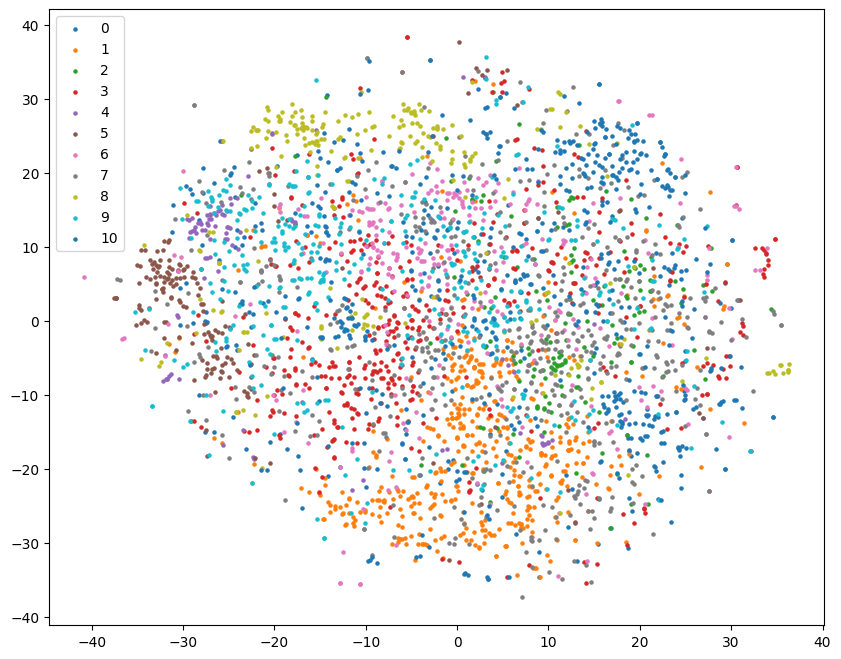

In [30]:
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    
features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()